# Preprocessing Pipeline for Structural Connectivity Matrices (FA)

This notebook includes:
- Loading clinical data and connectivity matrices.
- Detection of connections that are zero across all subjects.
- Imputation of zero values (Median and KNN).
- Covariate correction (age and sex).
- Reconstruction and saving of corrected matrices.
- Visualization of mean connectivity matrices by group (before and after correction).

In this preprocessing stage, two key steps are carried out to ensure data quality and mitigate confounding effects:

- **Covariate correction**: A linear regression model is applied to correct each connection value by removing the variability associated with the covariates age and sex. This correction is performed individually for each connection across all subjects, using the residuals of the model as corrected values.

- **Imputation of missing values**: To handle incomplete data in the connectivity matrices, an imputation procedure is applied. Two strategies are used: (i) replacement of missing values by the median of each connection, and (ii) K-Nearest Neighbors (KNN) imputation based on the 5 nearest subjects. In both cases, structurally absent connections (those with zero values across all subjects) are preserved and excluded from imputation.

# Explanations

- **Data loading and organization**: Structural connectivity matrices based on fractional anisotropy (FA) are used, corresponding to 178 subjects from the HCB cohort. The associated clinical data, including variables such as age, sex, and clinical condition (control or patient), are loaded from a .pkl file.

- **Matrix vectorization**: Each structural connectivity matrix (76×76) is vectorized by considering only the upper triangle (k=1), due to the symmetry of the matrices. This step reduces the dimensionality and avoids information redundancy, facilitating the subsequent statistical analyses.

- **Detection of structurally absent connections**: A procedure is implemented to detect those connections (region pairs) that present zero values in all subjects. These structurally absent connections are visualized using a heatmap and listed for inspection. These connections are not imputed, as there is no observational information about them.

- **Imputation of missing values**: For the remaining zero values, corresponding to connections with missing data in some subjects, two imputation strategies are applied:

    - *Median imputation*: Zero values are replaced by the median of the corresponding connection, calculated over the non-zero values.

    - *K-Nearest Neighbors (KNN) imputation*: Zero values are imputed using a model based on the 5 nearest neighbors (k=5). Columns corresponding to structurally absent connections are preserved with zero values.

- **Covariate correction**: A statistical correction is performed to remove the effect of confounding variables (age and sex) on the connectivity values. For this purpose, a linear regression model is fitted for each connection, using age and sex as predictors. The corrected values correspond to the residuals of the model.

- **Reconstruction and saving of corrected matrices**: From the corrected vectors, the full connectivity matrices (76×76) are reconstructed for each subject, maintaining their original symmetry. The corrected matrices are saved in .csv files, separately for each imputation strategy (median and KNN).

- **Visualization of group mean matrices**: Finally, the mean connectivity matrices are computed and visualized by group (controls vs patients) at two stages:

    - Before preprocessing (original matrices)

    - After imputation and covariate correction (for both strategies: median and KNN)

    These mean matrices allow for the evaluation of global differences in structural connectivity between groups and the effect of the preprocessing procedures applied.  

In [14]:
# ===========================
#    Preprocessing Pipeline
# ===========================
# For structural connectivity matrices (FA)
# Includes:
# - Loading clinical data and connectivity matrices
# - Detection of structurally absent connections
# - Imputation of zero values (Median, KNN)
# - Covariate correction (age, sex)
# - Reconstruction and saving of corrected matrices
# - Visualization of group mean matrices (before and after correction)

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import os
import glob

# === 1. Load clinical data ===
def load_dataframe(filepath):
    """
    Load clinical data from file, detecting format.

    Args:
        filepath (str or Path): Path to the clinical data file.

    Returns:
        DataFrame: Loaded clinical data.
    """
    if str(filepath).endswith('.pkl'):
        df = pd.read_pickle(filepath)
    elif str(filepath).endswith('.csv'):
        df = pd.read_csv(filepath)
    elif str(filepath).endswith('.parquet'):
        df = pd.read_parquet(filepath)
    elif str(filepath).endswith('.feather'):
        df = pd.read_feather(filepath)
    else:
        raise ValueError("❌ Unsupported file format.")
    
    print(f"✅ DataFrame loaded from {filepath}")
    return df

ruta_hcb = Path('F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB') 
clinic_df = load_dataframe(ruta_hcb / 'CLINIC_HCB.pkl')
clinic_df.set_index('id', inplace=True)


✅ DataFrame loaded from F:\Cursos\UOC Master Bio Inf. Est\M0.209 - UOC - TFM - Bio ML - Grafos\DATOS\MULTILAYER\DADES_HCB\CLINIC_HCB.pkl


⚠️ Number of connections always zero: 154


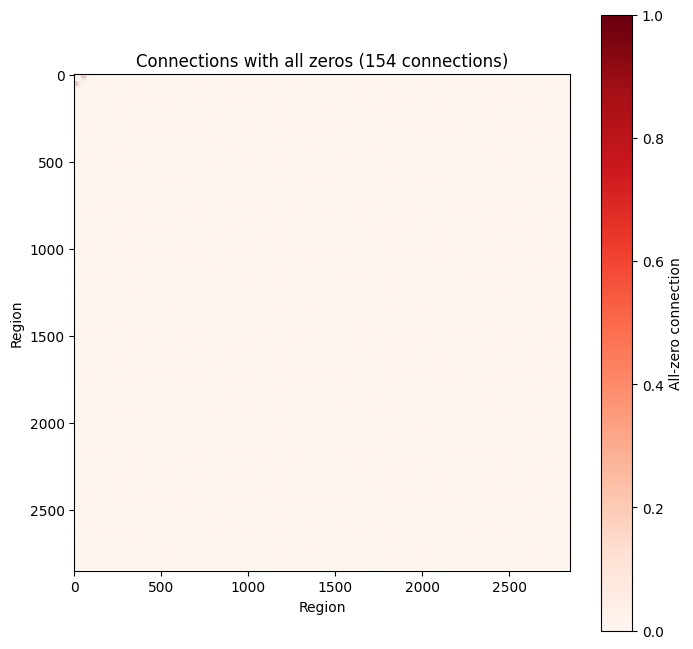

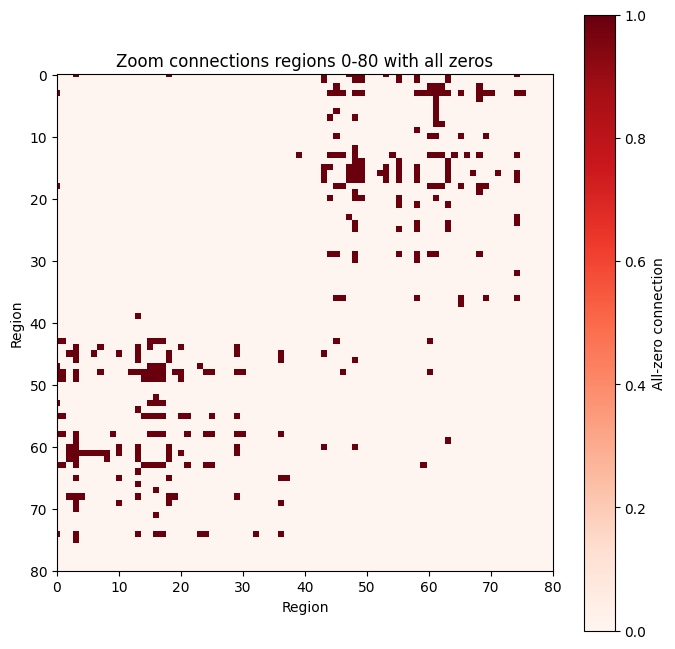


Number of connections always zero:
     Region_i  Region_j
0           0         3
1           0        18
2           0        43
3           0        47
4           0        48
..        ...       ...
149        43        45
150        43        60
151        46        48
152        48        60
153        59        63

[154 rows x 2 columns]


In [15]:

# === 2. Load FA matrices ===
def load_matrices_from_folder(folder_path):
    """
    Load all FA connectivity matrices from a folder.
    
    Args:
        folder_path (str): Path to the folder containing the matrices.

    Returns:
        dict: {subject_id: connectivity matrix}
    """
    matrices = {}
    file_list = glob.glob(os.path.join(folder_path, "*.csv"))
    # Extract subject IDs from filenames ("123456_FA_factor.csv" → "123456")
    for file in file_list:
        subj_id = os.path.basename(file).replace('_FA_factor.csv', '')
        # Convert DataFrame to array NumPy
        matrix = pd.read_csv(file, header=None).values
        # Save matrix in the dictionary (by id)
        matrices[subj_id] = matrix
    return matrices
    # "123456": array([[...], [...], ...]),

folder_path = "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/FA_networks"
fa_matrices = load_matrices_from_folder(folder_path)

# === 3. Vectorization ===
def vectorize_matrices(matrices):
    """
    Vectorize the upper triangle (k=1) of each connectivity matrix.

    Args:
        matrices (dict): {subject_id: connectivity matrix}

    Returns:
        DataFrame: Vectorized matrices (subjects x connections)
        tuple: Indices of upper triangle used.
    """
    vectors = {}
    for subj, matrix in matrices.items():
        # Return coordenates (indexes) from the upper triangular (not including the diagonal)
        # [[0, a, b],
        #  [a, 0, c],
        #  [b, c, 0]] -> Returns [a, b, c]
        triu_idx = np.triu_indices_from(matrix, k=1)
        vectors[subj] = matrix[triu_idx]
    return pd.DataFrame.from_dict(vectors, orient='index'), triu_idx

fa_vectors, triu_idx = vectorize_matrices(fa_matrices)

# === 4. Function to visualize connections with all zeros ===
def plot_zero_connections(df_vectors, triu_idx):
    """
    Detect and visualize connections (i, j) that are zero across all subjects.
    Also prints a table with these connections.

    Args:
        df_vectors (DataFrame): Vectorized connectivity matrices.
        triu_idx (tuple): Indices of upper triangle used in vectorization.

    Returns:
        zero_conn_indices (list): List of (i, j) pairs with all zeros.
    """
    # Detect connections (columns) where all subjects have zero
    zero_cols = df_vectors.columns[(df_vectors == 0).all()]
    print(f"⚠️ Number of connections always zero: {len(zero_cols)}")

    # Map back to (i, j) pairs
    zero_conn_indices = [(triu_idx[0][col], triu_idx[1][col]) for col in zero_cols]

    # === Mask for visualization for all zero ===
    n = len(triu_idx[0]) + 1
    mask = np.zeros((n, n))
    for i, j in zero_conn_indices:
        mask[i, j] = 1
        mask[j, i] = 1  # Symmetric
    
    plt.figure(figsize=(8, 8))  # Size of the figure
    plt.imshow(mask, cmap="Reds")
    plt.title(f"Connections with all zeros ({len(zero_conn_indices)} connections)")
    plt.xlabel("Region")
    plt.ylabel("Region")  
    plt.colorbar(label="All-zero connection")
    plt.show() 
    
    # === Zoomed-in view of the mask (0-80) ===
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap="Reds")
    plt.xlim(0, 80)  # Columnas 0 to 80
    plt.ylim(80, 0)  # Invert axis to see symetric
    plt.title("Zoom connections regions 0-80 with all zeros")    
    #plt.xticks(range(0, 81, 10), range(0, 81, 10))
    plt.xlabel("Region")
    plt.ylabel("Region")
    plt.colorbar(label="All-zero connection")
    plt.show()

    # === Summary able ===
    if zero_conn_indices:
        df_zero = pd.DataFrame(zero_conn_indices, columns=['Region_i', 'Region_j'])
        print("\nNumber of connections always zero:")
        print(df_zero)
    else:
        print("✅ NO All-zero connection")

    return zero_conn_indices

# Visualize connections "always zero" BEFORE pre-processing 
zero_conns = plot_zero_connections(fa_vectors, triu_idx)


In [16]:
# === 5A. Imputation by median preserving zero columns ===
def impute_median_preserve_zeros(df_vectors):
    """
    Impute zeros by the median value of each connection (column),
    preserving columns that are originally all zeros.

    Args:
        df_vectors (DataFrame): Vectorized connectivity matrices.

    Returns:
        DataFrame: Imputed matrices.
        list: Columns originally all zeros.
    """
    # Detect columns that are all zeros
    zero_cols = df_vectors.columns[(df_vectors == 0).all()]
    print(f"⚠️ Columns with all zeros detected and preserved: {len(zero_cols)}")

    # Remove those columns temporarily
    df_tmp = df_vectors.drop(columns=zero_cols)

    # Impute zeros by median for each column
    df_imputed = df_tmp.copy()
    for col in df_tmp.columns:
        non_zero = df_tmp[col][df_tmp[col] != 0]
        median = non_zero.median() if not non_zero.empty else 0
        df_imputed[col] = df_tmp[col].replace(0, median)

    # Add back the all-zero columns
    for col in zero_cols:
        df_imputed[col] = 0.0

    # Restore original column order
    df_imputed = df_imputed[df_vectors.columns]

    print("✅ Median imputation completed. All-zero columns preserved.")
    return df_imputed, zero_cols

# Apply median imputation preserving zeros
fa_vectors_median, zero_cols_median = impute_median_preserve_zeros(fa_vectors)

# === 5B. Imputation by KNN preserving zero columns ===
def impute_knn_preserve_zeros(df_vectors, n_neighbors=5):
    """
    Impute zeros using KNN, preserving columns that were originally all zeros.
    
    Args:
        df_vectors (DataFrame): Vectorized matrices.
        n_neighbors (int): Number of neighbors for KNN.

    Returns:
        DataFrame: Imputed matrices.
        list: Columns originally all zeros.
    """
     # Identify columns where all values are zero across subjects
    zero_cols = df_vectors.columns[(df_vectors == 0).all()]
    print(f"⚠️ Columns with all zeros detected and preserved: {len(zero_cols)}")
    
    # Temporarily remove all-zero columns from the dataset
    df_tmp = df_vectors.drop(columns=zero_cols)

    # Replace zeros with NaN for KNN imputation
    df_tmp = df_tmp.replace(0, np.nan)

    # Apply KNN imputation on remaining columns
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_array = imputer.fit_transform(df_tmp)

    # Convert the result back to a DataFrame
    df_imputed = pd.DataFrame(imputed_array, index=df_tmp.index, columns=df_tmp.columns)

    # Add back the previously removed all-zero columns, preserving them as 0.0
    for col in zero_cols:
        df_imputed[col] = 0.0

    # Restore original column order
    df_imputed = df_imputed[df_vectors.columns]

    print("✅ KNN imputation completed. All-zero columns preserved.")

    return df_imputed, zero_cols

fa_vectors_knn, zero_cols = impute_knn_preserve_zeros(fa_vectors, n_neighbors=5)

# === 6. Covariate correction ===
def correct_vectors_covariates(df_vectors, clinic_df, covariates=['age', 'sex']):
    """
    Correct each connection by covariates (age and sex) using linear regression.
    
    Args:
        df_vectors (DataFrame): Vectorized matrices.
        clinic_df (DataFrame): Clinical data.
        covariates (list): List of covariate names.

    Returns:
        DataFrame: Corrected matrices.
    """
    # Get subjects that are present in both connectivity and clinical data
    common_subjects = df_vectors.index.intersection(clinic_df.index)

    # Select the covariates and drop any subjects with missing values
    df_covars = clinic_df.loc[common_subjects, covariates].dropna()
    
    # Align the connectivity vectors to the subjects with valid covariates
    df_vectors = df_vectors.loc[df_covars.index]

    # Perform linear regression correction for each connection (column)
    corrected = pd.DataFrame(index=df_vectors.index, columns=df_vectors.columns)
    for col in df_vectors.columns:
        y = df_vectors[col].values
        X = df_covars.values
        model = LinearRegression().fit(X, y)
        residuals = y - model.predict(X)
        corrected[col] = residuals
    print("✅ Covariate correction completed.")
    return corrected

fa_vectors_median_corrected = correct_vectors_covariates(fa_vectors_median, clinic_df)
fa_vectors_knn_corrected = correct_vectors_covariates(fa_vectors_knn, clinic_df)

# === 7. Reconstruct and save corrected matrices ===
def reconstruct_and_save_with_zeros(corrected_vectors, original_triu_idx, output_dir, n_nodes=76):
    """
    Reconstruct and save corrected connectivity matrices preserving the original shape (n_nodes x n_nodes).

    Args:
        corrected_vectors (DataFrame): Corrected vectorized matrices.
        original_triu_idx (tuple): Indices of upper triangle used in vectorization.
        output_dir (str): Path to save the corrected matrices.
        n_nodes (int): Number of nodes in the connectivity matrices.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Number of unique connections (upper triangle)
    total_connections = len(original_triu_idx[0])

    # Process each subject individually
    for subj in corrected_vectors.index:
        # Initialize full connection vector (including any missing positions as zero)
        full_vector = np.zeros(total_connections)
        valid_cols = [col for col in corrected_vectors.columns]
        full_vector[valid_cols] = corrected_vectors.loc[subj].values

        # Reconstruct full symmetric matrix
        matrix = np.zeros((n_nodes, n_nodes))
        matrix[original_triu_idx] = full_vector
        matrix = matrix + matrix.T

        # Save the matrix to CSV
        output_path = os.path.join(output_dir, f"{subj}_FA_corrected.csv")
        pd.DataFrame(matrix).to_csv(output_path, index=False, header=False)

    print(f"✅ Corrected matrices saved in: {output_dir}")

# Save corrected matrices
reconstruct_and_save_with_zeros(
    corrected_vectors=fa_vectors_median_corrected,
    original_triu_idx=triu_idx,
    output_dir="F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/corrected_FA_matrices_median",
    n_nodes=76 # Dimensions of the matrix (76x76) - Original and corrected   
)

reconstruct_and_save_with_zeros(
    corrected_vectors=fa_vectors_knn_corrected,
    original_triu_idx=triu_idx,
    output_dir="F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/corrected_FA_matrices_knn",
    n_nodes=76 # Dimensions of the matrix (76x76) - Original and corrected
)


⚠️ Columns with all zeros detected and preserved: 154


C:\Users\alvar\AppData\Local\Temp\ipykernel_23396\3009810182.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_imputed[col] = 0.0
C:\Users\alvar\AppData\Local\Temp\ipykernel_23396\3009810182.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_imputed[col] = 0.0
C:\Users\alvar\AppData\Local\Temp\ipykernel_23396\3009810182.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

✅ Median imputation completed. All-zero columns preserved.
⚠️ Columns with all zeros detected and preserved: 154


C:\Users\alvar\AppData\Local\Temp\ipykernel_23396\3009810182.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_imputed[col] = 0.0
C:\Users\alvar\AppData\Local\Temp\ipykernel_23396\3009810182.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_imputed[col] = 0.0
C:\Users\alvar\AppData\Local\Temp\ipykernel_23396\3009810182.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

✅ KNN imputation completed. All-zero columns preserved.
✅ Covariate correction completed.
✅ Covariate correction completed.
✅ Corrected matrices saved in: F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/corrected_FA_matrices_median
✅ Corrected matrices saved in: F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/corrected_FA_matrices_knn


✅ Nº controls: 18
✅ Nº patients: 147


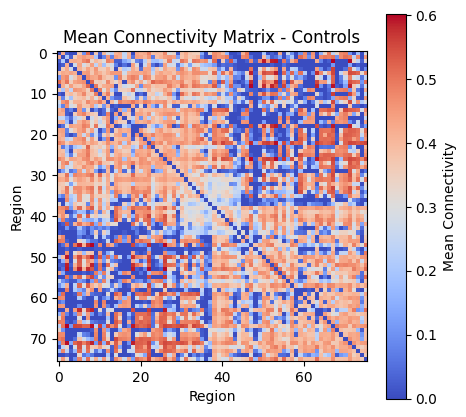

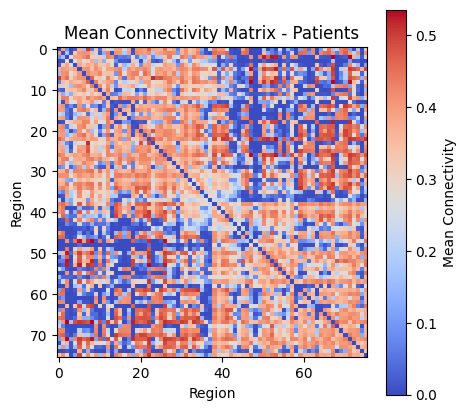

✅ Mean matrix saved to: F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_connectivity_controls_before.csv
✅ Mean matrix saved to: F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_connectivity_patients_before.csv


In [17]:
# === 9. Compute and visualize mean matrices by group (control - patient BEFORE correction) ===
def compute_group_mean_matrices(matrices_dict, clinic_df):
    """
    Compute the mean connectivity matrix for controls and patients separately.

    Args:
        matrices_dict (dict): Dictionary {subject_id: connectivity matrix}.
        clinic_df (DataFrame): Clinical data with 'controls_ms' column (0=control, 1=patient).

    Returns:
        mean_control (np.ndarray): Mean matrix for controls.
        mean_patient (np.ndarray): Mean matrix for patients.
    """
    # Get subject IDs per group
    control_ids = clinic_df[clinic_df['controls_ms'] == 0].index
    patient_ids = clinic_df[clinic_df['controls_ms'] == 1].index

    # Extract matrices per group
    control_matrices = [matrices_dict[subj] for subj in control_ids if subj in matrices_dict]
    patient_matrices = [matrices_dict[subj] for subj in patient_ids if subj in matrices_dict]

    # Compute mean matrices
    mean_control = np.mean(control_matrices, axis=0)
    mean_patient = np.mean(patient_matrices, axis=0)  

    print(f"✅ Nº controls: {len(control_matrices)}")
    print(f"✅ Nº patients: {len(patient_matrices)}")

    return mean_control, mean_patient

def plot_mean_matrix(matrix, title):
    """
    Plot a heatmap of the mean connectivity matrix.

    Args:
        matrix (np.ndarray): Mean connectivity matrix to display.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, cmap='coolwarm', vmin=np.min(matrix), vmax=np.max(matrix))
    plt.colorbar(label='Mean Connectivity')
    plt.title(title)
    plt.xlabel("Region")
    plt.ylabel("Region")
    plt.show()

def save_mean_matrix(matrix, output_path):
    """
    Save the mean matrix to CSV.
    
    Args:
        matrix (np.ndarray): Matrix to save.
        output_path (str): File path to save the CSV.
    """
    pd.DataFrame(matrix).to_csv(output_path, index=False, header=False)
    print(f"✅ Mean matrix saved to: {output_path}")

# Execution calculation, visualization and saving   
# Compute mean matrices for controls and patients
mean_control, mean_patient = compute_group_mean_matrices(fa_matrices, clinic_df)

# Visualization
plot_mean_matrix(mean_control, "Mean Connectivity Matrix - Controls")
plot_mean_matrix(mean_patient, "Mean Connectivity Matrix - Patients")

# Save mean matrices
save_mean_matrix(mean_control, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_connectivity_controls_before.csv")
save_mean_matrix(mean_patient, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_connectivity_patients_before.csv")


✅ Nº controls (corrected): 18
✅ Nº patients (corrected): 147
✅ Nº controls (corrected): 18
✅ Nº patients (corrected): 147


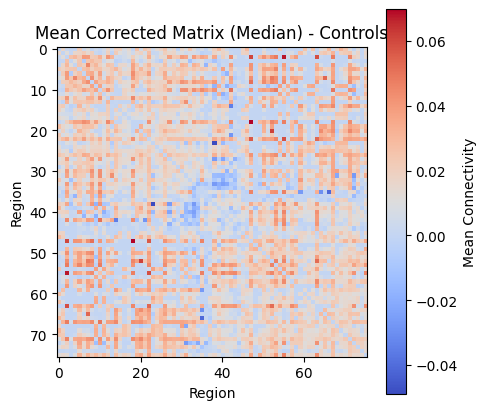

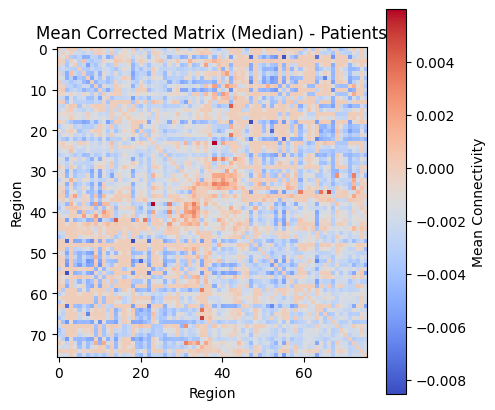

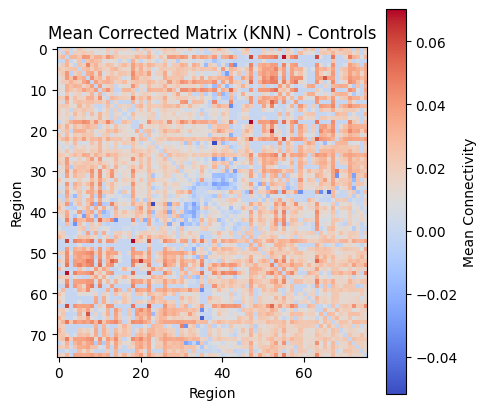

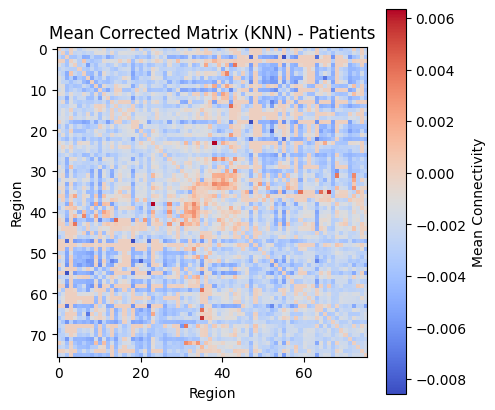

✅ Mean matrix saved to: F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_controls_median.csv
✅ Mean matrix saved to: F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_patients_median.csv
✅ Mean matrix saved to: F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_controls_knn.csv
✅ Mean matrix saved to: F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_patients_knn.csv


In [18]:

# === 10. Compute and visualize mean matrices AFTER correction ===
def compute_group_mean_corrected(corrected_vectors, original_triu_idx, clinic_df, n_nodes=76):
    """
    Compute the mean corrected connectivity matrix for controls and patients separately.

    Args:
        corrected_vectors (DataFrame): Corrected vectorized matrices.
        original_triu_idx (tuple): Upper triangle indices.
        clinic_df (DataFrame): Clinical data with 'controls_ms' column.
        n_nodes (int): Matrix size.

    Returns:
        mean_control (np.ndarray): Mean matrix for controls.
        mean_patient (np.ndarray): Mean matrix for patients.
    """
    # Get subject IDs per group
    control_ids = clinic_df[clinic_df['controls_ms'] == 0].index
    patient_ids = clinic_df[clinic_df['controls_ms'] == 1].index

    # Reconstruct matrices per subject
    matrices_control = []
    matrices_patient = []

    total_connections = len(original_triu_idx[0])

    for subj in corrected_vectors.index:
        # Build full connection vector (including zero-filled positions if needed)
        full_vector = np.zeros(total_connections)
        valid_cols = [col for col in corrected_vectors.columns]
        full_vector[valid_cols] = corrected_vectors.loc[subj].values

        # Reconstruct full matrix
        matrix = np.zeros((n_nodes, n_nodes))
        matrix[original_triu_idx] = full_vector
        matrix = matrix + matrix.T

         # Assign to group
        if subj in control_ids:
            matrices_control.append(matrix)
        elif subj in patient_ids:
            matrices_patient.append(matrix)

    # Compute mean matrices
    mean_control = np.mean(matrices_control, axis=0)
    mean_patient = np.mean(matrices_patient, axis=0)

    print(f"✅ Nº controls (corrected): {len(matrices_control)}")
    print(f"✅ Nº patients (corrected): {len(matrices_patient)}")

    return mean_control, mean_patient

#  Execution calculation, visualization and saving 
# Compute mean matrices for controls and patients (median & knn corrected)
mean_control_median, mean_patient_median = compute_group_mean_corrected(
    corrected_vectors=fa_vectors_median_corrected,
    original_triu_idx=triu_idx,
    clinic_df=clinic_df,
    n_nodes=76
)
mean_control_knn, mean_patient_knn = compute_group_mean_corrected(
    corrected_vectors=fa_vectors_knn_corrected,
    original_triu_idx=triu_idx,
    clinic_df=clinic_df,
    n_nodes=76
)

# Visualization
plot_mean_matrix(mean_control_median, "Mean Corrected Matrix (Median) - Controls")
plot_mean_matrix(mean_patient_median, "Mean Corrected Matrix (Median) - Patients")
plot_mean_matrix(mean_control_knn, "Mean Corrected Matrix (KNN) - Controls")
plot_mean_matrix(mean_patient_knn, "Mean Corrected Matrix (KNN) - Patients")

#  Save  matrices 
save_mean_matrix(mean_control_median, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_controls_median.csv")
save_mean_matrix(mean_patient_median, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_patients_median.csv")
save_mean_matrix(mean_control_knn, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_controls_knn.csv")
save_mean_matrix(mean_patient_knn, "F:/Cursos/UOC Master Bio Inf. Est/M0.209 - UOC - TFM - Bio ML - Grafos/DATOS/MULTILAYER/DADES_HCB/output/FA_mean_corrected_patients_knn.csv")
